In [1]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)  #导入数据

我们每次采样的小批量数据形状是二维张量： （批量大小，时间步数）。 one_hot函数将这样一个小批量数据转换成三维张量， 张量的最后一个维度等于词表大小（len(vocab)）。 我们经常转换输入的维度，以便获得形状为 （时间步数，批量大小，词表大小）的输出。 这将使我们能够更方便地通过最外层的维度， 一步一步地更新小批量数据的隐状态。

In [2]:
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [3]:
X = torch.arange(10).reshape((2, 5))
print(F.one_hot(X.T, 28))
print(F.one_hot(X.T, 28).shape)

tensor([[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0

# 初始化模型参数

初始化循环神经网络模型的模型参数。 隐藏单元数num_hiddens是一个可调的超参数。 当训练语言模型时，输入和输出来自相同的词表。 因此，它们具有相同的维度，即词表的大小。

In [4]:
def get_params(vocab_size, num_hiddens, device):
    # 词表大小，隐藏层数目，所用设备
    num_inputs = num_outputs = vocab_size   #定义输入词表的大小和输出词表的大小都等于词表大小

    def normal(shape):  #生成0.0-0.1之间的特定形状的正态分布参数
        return torch.randn(size=shape, device=device) * 0.01

    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))    #输入特征与隐藏层之间的连接权重
    W_hh = normal((num_hiddens, num_hiddens))   #隐藏层在时间维度上的自连接权重，用于传递和更新隐藏状态，捕捉时间依赖关系
    b_h = torch.zeros(num_hiddens, device=device)   #隐藏层的偏置项
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))   #隐藏层与输出层之间的连接权重
    b_q = torch.zeros(num_outputs, device=device)   #输出层的偏置项
    # 附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params


为了定义循环神经网络模型， 我们首先需要一个init_rnn_state函数在初始化时返回隐状态。 这个函数的返回是一个张量，张量全用0填充， 形状为（批量大小，隐藏单元数）。 在后面的章节中我们将会遇到隐状态包含多个变量的情况， 而使用元组可以更容易地处理些。

In [5]:
def init_rnn_state(batch_size, num_hiddens, device):    #初始化隐藏层状态
    return (torch.zeros((batch_size, num_hiddens), device=device), )

In [6]:
(torch.zeros((5,3)), )

(tensor([[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]),)

下面的rnn函数定义了如何在一个时间步内计算隐状态和输出。 循环神经网络模型通过inputs最外层的维度实现循环， 以便逐时间步更新小批量数据的隐状态H。 此外，这里使用tanh函数作为激活函数。如4.1节所述，当元素在实数上满足均匀分布时，tanh函数的平均值为0。


在下面这个函数中，输入参数inputs是一个形状为(时间步数量，批量大小，词表大小)的3维Tensor。

当输入序列是文本序列时，可以将 `inputs` 表示为一个包含词表索引的三维张量。以下是一个示例，假设批量大小为2，时间步数量为3，词表大小为4：

```
inputs = torch.tensor([[[0, 1, 2, 3],    # 时间步1，批量1
                       [1, 2, 3, 0]],   # 时间步1，批量2

                      [[3, 2, 1, 0],    # 时间步2，批量1
                       [2, 1, 0, 3]],   # 时间步2，批量2

                      [[0, 3, 2, 1],    # 时间步3，批量1
                       [3, 0, 1, 2]]])  # 时间步3，批量2
```

这个示例中，时间步数量为3，批量大小为2，词表大小为4。每个时间步的输入是一个包含4个词表索引的一维张量，表示一个样本的词表序列。

In [7]:
def rnn(inputs, state, params):
    """循环神经网络的前向传播逻辑"""
    # inputs的形状：(时间步数量，批量大小，词表大小)
    # state：一个存有隐藏层状态的元组，初始为(init_state,)（init_rnn_state生成）
    W_xh, W_hh, b_h, W_hq, b_q = params     #自定义初始化参数（get_params）
    H, = state  #从当前状态中解包得到隐藏层状态H
    outputs = []
    # X的形状：(批量大小，词表大小)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h) #更新隐藏层状态H
        Y = torch.mm(H, W_hq) + b_q     #输出结果Y
        outputs.append(Y)               #将输出结果Y保存至outputs列表中
    return torch.cat(outputs, dim=0), (H,)  #返回输出结果和隐藏层状态元组


定义了所有需要的函数之后，接下来我们创建一个类来包装这些函数， 并存储从零开始实现的循环神经网络模型的参数。

In [8]:
class RNNModelScratch: #@save
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device, get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens #词表大小（输入的词汇量）、隐藏层数目
        self.params = get_params(vocab_size, num_hiddens, device)   #权重参数
        self.init_state, self.forward_fn = init_state, forward_fn   #初始化权重参数、前向传播函数

    def __call__(self, X, state):
        # X的形状：(seq_len,batch_size)
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32) #独热编码，编码的长度为词表大小
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [9]:
num_hiddens = 512   #隐藏层数目
# 创建rnn对象
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params, init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())  #开始状态，X形状(steps,batch_size)，转置之后X每一行代表一个batch，每一列代表一个step
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

我们可以看到输出形状是（时间步数批量大小，词表大小）， 而隐状态形状保持不变，即（批量大小，隐藏单元数）。

# 预测

让我们首先定义预测函数来生成prefix之后的新字符， 其中的prefix是一个用户提供的包含多个字符的字符串。 在循环遍历prefix中的开始字符时， 我们不断地将隐状态传递到下一个时间步，但是不生成任何输出。 这被称为预热（warm-up）期， 因为在此期间模型会自我更新（例如，更新隐状态）， 但不会进行预测。 预热期结束后，隐状态的值通常比刚开始的初始值更适合预测， 从而预测字符并输出它们。

In [10]:
def predict_ch8(prefix,num_preds,net,vocab,device):
    """在prefix后面生成新字符"""
    # prefix：字符串，num_preds：要生成的字符数量，net：RNN模型，vocab：词汇表，device：运行设备
    state=net.begin_state(batch_size=1,device=device)   #设置隐藏层的初始状态
    outputs=[vocab[prefix[0]]]  #使用prefix中第一个字符的索引初始化outputs列表，这将成为生成新字符的起始点
    get_input = lambda:torch.tensor([outputs[-1]],device=device).reshape((1,1)) #返回最后一个输出字符作为张量，用于在预测过程中提供输入给rnn模型
    #预热期
    for y in prefix[1:]:    #遍历prefix中除第一个字符之外的每个字符
        _,state=net(get_input(),state)  #将输入张量和当前状态提供给RNN模型，并丢弃输出张量
        outputs.append(vocab[y])    #将当前字符y的索引追加到outputs列表中，以通过已知的前缀来预热RNN模型
    for _ in range(num_preds):  #生成num_preds个新字符
        y,state=net(get_input(),state)  #将上一步的输出和隐藏层状态输入net模型中，获取输出张量和y更新后的状态
        outputs.append(int(y.argmax(dim=1).reshape(1))) #将预测字符的索引追加到outputs列表中
    return ''.join([vocab.idx_to_token[i] for i in outputs])    #将outputs转换回字符串并返回

现在我们可以测试predict_ch8函数。 我们将前缀指定为time traveller， 并基于这个前缀生成10个后续字符。 鉴于我们还没有训练网络，它会生成荒谬的预测结果。

In [11]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller gzhxyfoycr'

# 梯度裁剪
下面我们定义一个函数来裁剪模型的梯度， 模型是从零开始实现的模型或由高级API构建的模型。 我们在此计算了所有模型参数的梯度的范数。

In [12]:
def grad_clipping(net, theta):  #@save
    """裁剪梯度"""
    if isinstance(net, nn.Module):  #如果net是nn.Module的实例
        params = [p for p in net.parameters() if p.requires_grad]   #取出net模型中所有需要进行学习和更新的参数，存为params列表
    else:
        params = net.params #如果net是自定义模型的实例，获取自定义模型中定义的权重参数
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))    #计算模型参数梯度的L2范数，表示梯度在整个参数空间上的大小。这个值可以用来评估梯度的大小，进而用于梯度裁剪、正则化等优化算法的调整
    if norm > theta:    #如果L2范数超出阈值
        for param in params:
            param.grad[:] *= theta / norm

在机器学习和优化算法中，L2范数经常被用来表示模型参数的大小，或者用于正则化项的惩罚项。L2范数较大的模型参数表示模型的复杂度较高，可能容易过拟合，因此在优化过程中通过添加L2正则化来约束模型参数的大小，从而提高模型的泛化能力。此外，L2范数也常用于计算梯度的大小，用于梯度裁剪和学习率调整等操作。

# 训练

在训练模型之前，让我们定义一个函数在一个迭代周期内训练模型。 它与我们训练 3.6节模型的方式有三个不同之处。

* 序列数据的不同采样方法（随机采样和顺序分区）将导致隐状态初始化的差异。

* 我们在更新模型参数之前裁剪梯度。 这样的操作的目的是，即使训练过程中某个点上发生了梯度爆炸，也能保证模型不会发散。

* 我们用困惑度来评价模型。如 8.4.4节所述， 这样的度量确保了不同长度的序列具有可比性。

具体来说，当使用顺序分区时， 我们只在每个迭代周期的开始位置初始化隐状态。 由于下一个小批量数据中的第
个子序列样本 与当前第

个子序列样本相邻， 因此当前小批量数据最后一个样本的隐状态， 将用于初始化下一个小批量数据第一个样本的隐状态。 这样，存储在隐状态中的序列的历史信息 可以在一个迭代周期内流经相邻的子序列。 然而，在任何一点隐状态的计算， 都依赖于同一迭代周期中前面所有的小批量数据， 这使得梯度计算变得复杂。 为了降低计算量，在处理任何一个小批量数据之前， 我们先分离梯度，使得隐状态的梯度计算总是限制在一个小批量数据的时间步内。

当使用随机抽样时，因为每个样本都是在一个随机位置抽样的， 因此需要为每个迭代周期重新初始化隐状态。 与 3.6节中的 train_epoch_ch3函数相同， updater是更新模型参数的常用函数。 它既可以是从头开始实现的d2l.sgd函数， 也可以是深度学习框架中内置的优化函数。

In [13]:
#@save
def train_epoch_ch8(net,train_iter,loss,updater,device,use_random_iter):
    """训练网络一个迭代周期"""
    # 输入参数（模型，训练数据集，损失函数，优化器，设备类型，是否使用随机抽样
    state,timer=None,d2l.Timer()# 初始化变量state和计时器timer
    metric=d2l.Accumulator(2)#metricsAccumulator的一个实例，用于累加训练损失和词元数量
    for X,Y in train_iter:#访问训练数据集，每次迭代返回一个X和Y
        if state is None or use_random_iter:
            #在第一次迭代货使用随机抽样时初始化state
            state =net.begin_state(batch_size=X.shape[0],device=device)#调用 net.begin_state() 函数初始化 state
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()#将 state 分离（detached）出来
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()#分别分离 state 中的每个元素
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)#使用当前网络模型和当前状态 state 计算输出结果 y_hat 和新状态 state
        l = loss(y_hat, y.long()).mean()#y.long()表示将张量y转换为整数类型的张量
        if isinstance(updater, torch.optim.Optimizer):#如果使用 PyTorch 内置的优化器
            updater.zero_grad() #梯度清零
            l.backward()    #反向传播
            grad_clipping(net, 1)   #梯度截断
            updater.step()  #梯度更新
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了mean函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())#y.numel()表示张量y中元素的个数
    # 返回每个词元的平均困惑度（通过对训练损失取指数）和每秒处理的词元数量（通过计时器timer来计算）
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()
"""
在这段代码中，`metrics` 的作用是累加训练损失值和词元数量。具体来说，在每次迭代中，计算出当前小批量数据的损失值 `l` 和该小批量数据所包含的词元数量 `y.numel()`，然后使用类 `d2l.Accumulator` 实例的 `add()` 方法将它们加起来。最终，`metrics[0]` 存储了所有小批量数据的损失之和，而 `metrics[1]` 存储了所有小批量数据的词元数量之和，可以用于计算困惑度等指标。
"""

'\n在这段代码中，`metrics` 的作用是累加训练损失值和词元数量。具体来说，在每次迭代中，计算出当前小批量数据的损失值 `l` 和该小批量数据所包含的词元数量 `y.numel()`，然后使用类 `d2l.Accumulator` 实例的 `add()` 方法将它们加起来。最终，`metrics[0]` 存储了所有小批量数据的损失之和，而 `metrics[1]` 存储了所有小批量数据的词元数量之和，可以用于计算困惑度等指标。\n'

困惑度（perplexity）是评价语言模型好坏的一种指标。在自然语言处理中，语言模型的目标是预测一个给定的单词序列的概率。可以用困惑度来描述语言模型的性能。

如果一个语言模型的困惑度为 $p$，那么它预测下一个单词的平均选项数就是 $p$ 个。换句话说，困惑度越低，语言模型性能越好。通常情况下，困惑度的计算公式如下：

$$\text{perplexity} = \sqrt[N]{\prod_{i=1}^N \frac{1}{P(w_i|w_1, \ldots, w_{i-1})}}$$

其中，$N$ 是语料库的总词数，$w_1, \ldots, w_N$ 是语料库中的单词序列，$P(w_i|w_1, \ldots, w_{i-1})$ 是语言模型根据前 $i-1$ 个单词预测第 $i$ 个单词的条件概率。简单来说，每个单词都有一个预测概率，所有单词的预测概率的乘积取倒数再开 N 次方得到的结果就是困惑度。

## 困惑度VS召回率

困惑度和召回率是机器学习中常用的评估指标，它们之间存在一定的关系。

困惑度（Perplexity）是一个语言模型的指标，用于评估该模型对样本数据的拟合程度。它通常被定义为对数似然函数的负数平均值，即：perplexity = exp(-1/N * Σ(log P(w_i))),其中 N 是测试集中单词的总数，P(w_i) 是该模型预测单词 w_i 的概率。困惑度越小，表示该模型对训练数据的拟合程度越好。

召回率（Recall）是分类模型的指标之一，用于评估该模型对正例样本的识别能力。它通常被定义为在所有正例样本中正确预测出来的样本数量与所有正例样本数量的比值，即：Recall = TP / (TP + FN)，其中 TP 表示真正例样本的数量，FN 表示被错误分类为负例的正例样本数量。召回率越高，表示该模型对正例样本的识别能力越强。

在一些自然语言处理任务中，如文本分类、情感分析等，可以使用困惑度作为评估指标来衡量模型对文本的理解程度。而在这些任务中，召回率也是一个重要的评估指标，它可以用来评估模型对于某个类别的文本的识别能力。因此，困惑度和召回率之间存在一定的关系，二者都可以用来评估模型的性能表现。

循环神经网络模型的训练函数既支持从零开始实现， 也可以使用高级API来实现

In [14]:
#@save
def train_ch8(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False):
    """训练模型（定义见第8章）"""
    # 输入参数：（模型，训练数据，词表，学习率，迭代次数，设备，是否使用随机抽样）
    loss = nn.CrossEntropyLoss()    #定义损失函数为交叉熵函数
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity', legend=['train'], xlim=[10, num_epochs])   #实时画图
    # 初始化更新器
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr) #随机梯度下降
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)    #自定义更新器
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)    #定义预测的lambda表达式
    # 训练和预测
    for epoch in range(num_epochs): # 对每一次迭代
        # 调用train_epoch_ch8函数训练网络的一个迭代周期
        # ppl：每个词元的平均困惑度，speed：每秒处理的词元数量
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:   #每10代输出一次结果
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

`train_ch8`函数和`train_epoch_ch8`函数是相互关联的，它们共同完成了模型的训练过程。

- `train_epoch_ch8`函数是训练过程中的一个迭代周期，它接受一个批次的训练数据并对模型进行参数更新。在每个迭代周期内，它使用给定的损失函数、参数更新器和设备对模型进行训练，并返回训练损失和处理速度。

- `train_ch8`函数是整个训练过程的主函数。它使用`train_epoch_ch8`函数对模型进行多个迭代周期的训练，并在每个固定的迭代周期内输出训练结果和生成的文本序列预测。它还创建了损失函数、动画对象和参数更新器，并将它们作为参数传递给`train_epoch_ch8`函数。

总的来说，`train_ch8`函数是用于控制整个训练过程的主函数，而`train_epoch_ch8`函数是用于完成单个迭代周期的训练的子函数。它们之间通过参数传递和函数调用的方式进行联系，共同完成了模型的训练过程。

现在，我们训练循环神经网络模型。 因为我们在数据集中只使用了10000个词元， 所以模型需要更多的迭代周期来更好地收敛。

困惑度 1.0, 67879.8 词元/秒 cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


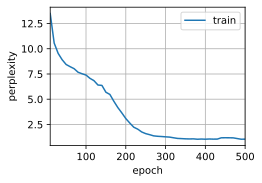

In [15]:
num_epochs,lr=500,1
train_ch8(net,train_iter,vocab,lr,num_epochs,d2l.try_gpu())

最后，让我们检查一下使用随机抽样方法的结果。

困惑度 1.5, 64473.8 词元/秒 cuda:0
time traveller proceeded anyreal body must have extension in fou
travellerit would be remarkably convenient for the historia


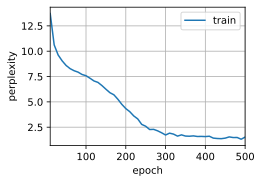

In [16]:
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params, init_rnn_state, rnn)
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(), use_random_iter=True)

# 顺序分区和随机抽样

顺序分区（Sequential Partitioning）和随机抽样（Random Sampling）是在训练数据中选择批次的两种常见方法。它们在数据的选择方式和训练过程中的数据顺序上有所不同，从而对结果产生不同的影响。

1. 顺序分区：顺序分区是将训练数据按照顺序划分为多个批次。在每个迭代周期中，按顺序依次选择下一个批次作为训练数据。这意味着每个样本都会被依次使用，并且在相邻的迭代中可能存在高度相关性。顺序分区通常用于处理序列数据，例如自然语言处理任务中的文本序列。

2. 随机抽样：随机抽样是在训练数据中随机选择批次。在每个迭代周期中，从训练数据中随机抽取一个批次作为训练数据，样本的顺序是随机的。这意味着每个样本的选择是独立的，样本之间的相关性较低。随机抽样通常用于处理非序列数据，例如图像分类任务中的图像数据。

区别和影响：
- 数据选择方式：顺序分区按照顺序选择数据，随机抽样随机选择数据。顺序分区保持了样本之间的顺序关系，而随机抽样破坏了样本之间的顺序关系。
- 数据相关性：顺序分区中相邻批次之间可能存在高度相关性，而随机抽样独立地选择样本，样本之间相关性较低。
- 训练过程：顺序分区通常用于处理序列数据，可以捕捉到数据中的时间关系和上下文信息。随机抽样对于非序列数据更为适用，样本之间的顺序不太重要。
- 收敛速度和泛化能力：顺序分区可能在训练过程中更快地收敛，但可能会过度依赖相邻样本的相关性。随机抽样可以更好地泛化到未见过的数据，但可能需要更多的迭代才能达到收敛。

选择顺序分区还是随机抽样取决于数据的性质和任务的要求。对于序列数据或有时间关系的任务，顺序分区可能更合适。对于非序列数据或需要更好的泛化能力的任务，随机抽样可能更合适。有时候也可以通过交替使用两种方式来获得一些平衡。